In [1]:
# from swt import SWTScrubber
# import ocr
import re

# import bodydetector as bt
# import find_bibs as bf
# from bib import Bib
# import BibTaggerResult as bibTaggerResult


In [2]:
class BibTaggerResult(object):
    def __init__(self):
        self.faces = 0
        self.bibs = 0
        self.swt = 0
        self.bib_numbers = []

    def __str__(self):
        return "Result: {0} faces, {1} bibs, {2} SWT, {3} bib numbers: ({4})".format(self.faces, self.bibs, self.swt,
                                                                                     len(self.bib_numbers),
                                                                                     self.bib_numbers)


In [30]:
from __future__ import division
from collections import defaultdict

import math
import os

import cv2
import scipy.sparse, scipy.spatial


diagnostics = False


class SWTScrubber(object):
    @classmethod
    def scrub(cls, image):
        """
        Apply Stroke-Width Transform to image.

        :param filepath: relative or absolute filepath to source image
        :return: numpy array representing result of transform
        """

        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        plt.imshow(gray)
        plt.show()

        canny, sobelx, sobely, theta = cls._create_derivative(gray)
        swt = cls._swt(theta, canny, sobelx, sobely)
        shapes = cls._connect_components(swt)
        swts, heights, widths, topleft_pts, images = cls._find_letters(swt, shapes)
        if(len(swts)==0):
            #didn't find any text, probably a bad face
            return None

        word_images = cls._find_words(swts, heights, widths, topleft_pts, images)
        print("word_images", word_images)
        final_mask = np.zeros(swt.shape)
        for word in word_images:
            final_mask += word
        return final_mask

    @classmethod
    def _create_derivative(cls, img):
        edges = cv2.Canny(img, 175, 320, apertureSize=3)
        # Create gradient map using Sobel
        sobelx64f = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=-1)
        sobely64f = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=-1)

        theta = np.arctan2(sobely64f, sobelx64f)
        if diagnostics:
            cv2.imwrite('edges.jpg',edges)
            cv2.imwrite('sobelx64f.jpg', np.absolute(sobelx64f))
            cv2.imwrite('sobely64f.jpg', np.absolute(sobely64f))
            # amplify theta for visual inspection
            theta_visible = (theta + np.pi)*255/(2*np.pi)
            cv2.imwrite('theta.jpg', theta_visible)
        return (edges, sobelx64f, sobely64f, theta)

    @classmethod
    def _swt(self, theta, edges, sobelx64f, sobely64f):
        # create empty image, initialized to infinity
        swt = np.empty(theta.shape)
        swt[:] = np.Infinity
        rays = []


        # now iterate over pixels in image, checking Canny to see if we're on an edge.
        # if we are, follow a normal a ray to either the next edge or image border
        # edgesSparse = scipy.sparse.coo_matrix(edges)
        step_x_g = -1 * sobelx64f
        step_y_g = -1 * sobely64f
        mag_g = np.sqrt( step_x_g * step_x_g + step_y_g * step_y_g )
        grad_x_g = step_x_g / mag_g
        grad_y_g = step_y_g / mag_g

        for x in range(edges.shape[1]):
            for y in range(edges.shape[0]):
                if edges[y, x] > 0:
                    step_x = step_x_g[y, x]
                    step_y = step_y_g[y, x]
                    mag = mag_g[y, x]
                    grad_x = grad_x_g[y, x]
                    grad_y = grad_y_g[y, x]
                    ray = []
                    ray.append((x, y))
                    prev_x, prev_y, i = x, y, 0
                    while True:
                        i += 1
                        
                        #edited
                        if math.isnan(grad_x):
                            break
                      
                        cur_x = math.floor(x + grad_x * i)
                        cur_y = math.floor(y + grad_y * i)
                            
                        if cur_x != prev_x or cur_y != prev_y:
                            # we have moved to the next pixel!
                            try:
                                # Detect if we have just "stepped through" a line on the diagonal
                                if (prev_x != x and prev_y != y and cur_x != prev_x and cur_y != prev_y):
                                    if edges[cur_y, prev_x] > 0 and edges[prev_y, cur_x] > 0:
                                        break

                                if edges[cur_y, cur_x] > 0:
                                    # found edge,
                                    ray.append((cur_x, cur_y))
                                    theta_point = theta[y, x]
                                    alpha = theta[cur_y, cur_x]
                                    val = grad_x * -grad_x_g[cur_y, cur_x] + grad_y * -grad_y_g[cur_y, cur_x]
                                    if (val < -1.0):
                                        val = -1.0
                                    if (val > 1.0):
                                        val = 1.0
                                    if math.acos(val) < np.pi/2.0:
                                        thickness = math.sqrt( (cur_x - x) * (cur_x - x) + (cur_y - y) * (cur_y - y) )
                                        for (rp_x, rp_y) in ray:
                                            swt[rp_y, rp_x] = min(thickness, swt[rp_y, rp_x])
                                        rays.append(ray)
                                    break
                                # this is positioned at end to ensure we don't add a point beyond image boundary
                                ray.append((cur_x, cur_y))
                            except IndexError:
                                # reached image boundary
                                break
                            prev_x = cur_x
                            prev_y = cur_y

        # Compute median SWT
        for ray in rays:
            median = np.median([swt[y, x] for (x, y) in ray])
            for (x, y) in ray:
                swt[y, x] = min(median, swt[y, x])
        if diagnostics:
            cv2.imwrite('swt.jpg', swt * 100)

        return swt

    @classmethod
    def _connect_components(cls, swt):
        # STEP: Compute distinct connected components
        # Implementation of disjoint-set
        class Label(object):
            def __init__(self, value):
                self.value = value
                self.parent = self
                self.rank = 0
            def __eq__(self, other):
                if type(other) is type(self):
                    return self.value == other.value
                else:
                    return False
            def __ne__(self, other):
                return not self.__eq__(other)

        ld = {}

        def MakeSet(x):
            try:
                return ld[x]
            except KeyError:
                item = Label(x)
                ld[x] = item
                return item

        def Find(item):
            # item = ld[x]
            if item.parent != item:
                item.parent = Find(item.parent)
            return item.parent

        def Union(x, y):
            """
            :param x:
            :param y:
            :return: root node of new union tree
            """
            x_root = Find(x)
            y_root = Find(y)
            if x_root == y_root:
                return x_root

            if x_root.rank < y_root.rank:
                x_root.parent = y_root
                return y_root
            elif x_root.rank > y_root.rank:
                y_root.parent = x_root
                return x_root
            else:
                y_root.parent = x_root
                x_root.rank += 1
                return x_root

        # apply Connected Component algorithm, comparing SWT values.
        # components with a SWT ratio less extreme than 1:3 are assumed to be
        # connected. Apply twice, once for each ray direction/orientation, to
        # allow for dark-on-light and light-on-dark texts
        trees = {}
        # Assumption: we'll never have more than 65535-1 unique components
        label_map = np.zeros(shape=swt.shape, dtype=np.uint16)
        next_label = 1
        # First Pass, raster scan-style
        swt_ratio_threshold = 3.0
        for y in range(swt.shape[0]):
            for x in range(swt.shape[1]):
                sw_point = swt[y, x]
                if sw_point < np.Infinity and sw_point > 0:
                    neighbors = [(y, x-1),   # west
                                 (y-1, x-1), # northwest
                                 (y-1, x),   # north
                                 (y-1, x+1)] # northeast
                    connected_neighbors = None
                    neighborvals = []

                    for neighbor in neighbors:
                        # west
                        try:
                            sw_n = swt[neighbor]
                            label_n = label_map[neighbor]
                        except IndexError:
                            continue
                        if label_n > 0 and sw_n / sw_point < swt_ratio_threshold and sw_point / sw_n < swt_ratio_threshold:
                            neighborvals.append(label_n)
                            if connected_neighbors:
                                connected_neighbors = Union(connected_neighbors, MakeSet(label_n))
                            else:
                                connected_neighbors = MakeSet(label_n)

                    if not connected_neighbors:
                        # We don't see any connections to North/West
                        trees[next_label] = (MakeSet(next_label))
                        label_map[y, x] = next_label
                        next_label += 1
                    else:
                        # We have at least one connection to North/West
                        label_map[y, x] = min(neighborvals)
                        # For each neighbor, make note that their respective connected_neighbors are connected
                        # for label in connected_neighbors. @todo: do I need to loop at all neighbor trees?
                        trees[connected_neighbors.value] = Union(trees[connected_neighbors.value], connected_neighbors)

        # Second pass. re-base all labeling with representative label for each connected tree
        layers = {}
        contours = defaultdict(list)
        for x in range(swt.shape[1]):
            for y in range(swt.shape[0]):
                if label_map[y, x] > 0:
                    item = ld[label_map[y, x]]
                    common_label = Find(item).value
                    label_map[y, x] = common_label
                    contours[common_label].append([x, y])
                    try:
                        layer = layers[common_label]
                    except KeyError:
                        layers[common_label] = np.zeros(shape=swt.shape, dtype=np.uint16)
                        layer = layers[common_label]

                    layer[y, x] = 1
        return layers

    @classmethod
    def _find_letters(cls, swt, shapes):
        # STEP: Discard shapes that are probably not letters
        swts = []
        heights = []
        widths = []
        topleft_pts = []
        images = []

        for label,layer in shapes.items():
            (nz_y, nz_x) = np.nonzero(layer)
            east, west, south, north = max(nz_x), min(nz_x), max(nz_y), min(nz_y)
            width, height = east - west, south - north

            if width < 8 or height < 8:
                continue

            if width / height > 10 or height / width > 10:
                continue

            if float(width) / height > 3.0:
                continue

            diameter = math.sqrt(width * width + height * height)
            median_swt = np.median(swt[(nz_y, nz_x)])
            if diameter / median_swt > 10:
                continue

            if width / layer.shape[1] > 0.4 or height / layer.shape[0] > 0.4:
                continue

            if diagnostics:
                print(" written to image.")
                cv2.imwrite('layer'+ str(label) +'.jpg', layer * 255)

            # we use log_base_2 so we can do linear distance comparison later using k-d tree
            # ie, if log2(x) - log2(y) > 1, we know that x > 2*y
            # Assumption: we've eliminated anything with median_swt == 1
            swts.append([math.log(median_swt, 2)])
            heights.append([math.log(height, 2)])
            topleft_pts.append(np.asarray([north, west]))
            widths.append(width)
            images.append(layer)

        return swts, heights, widths, topleft_pts, images

    @classmethod
    def _find_words(cls, swts, heights, widths, topleft_pts, images):
        # Find all shape pairs that have similar median stroke widths

        #print 'SWTS'
        #print swts
        #print 'DONESWTS'

        swt_tree = scipy.spatial.KDTree(np.asarray(swts))
        stp = swt_tree.query_pairs(1)

        # Find all shape pairs that have similar heights
        height_tree = scipy.spatial.KDTree(np.asarray(heights))
        htp = height_tree.query_pairs(1)

        # Intersection of valid pairings
        isect = htp.intersection(stp)

        chains = []
        pairs = []
        pair_angles = []
        for pair in isect:
            left = pair[0]
            right = pair[1]
            widest = max(widths[left], widths[right])
            distance = np.linalg.norm(topleft_pts[left] - topleft_pts[right])
            if distance < widest * 1.5:
                delta_yx = topleft_pts[left] - topleft_pts[right]
                angle = np.arctan2(delta_yx[0], delta_yx[1])
                if angle < 0:
                    angle += np.pi

                pairs.append(pair)
                pair_angles.append(np.asarray([angle]))

        atp = []
        if len(pair_angles) > 0:
            angle_tree = scipy.spatial.KDTree(np.asarray(pair_angles))
            atp = angle_tree.query_pairs(np.pi/12)

        for pair_idx in atp:
            pair_a = pairs[pair_idx[0]]
            pair_b = pairs[pair_idx[1]]
            left_a = pair_a[0]
            right_a = pair_a[1]
            left_b = pair_b[0]
            right_b = pair_b[1]

            # @todo - this is O(n^2) or similar, extremely naive. Use a search tree.
            added = False
            for chain in chains:
                if left_a in chain:
                    chain.add(right_a)
                    added = True
                elif right_a in chain:
                    chain.add(left_a)
                    added = True
            if not added:
                chains.append(set([left_a, right_a]))
            added = False
            for chain in chains:
                if left_b in chain:
                    chain.add(right_b)
                    added = True
                elif right_b in chain:
                    chain.add(left_b)
                    added = True
            if not added:
                chains.append(set([left_b, right_b]))

        word_images = []
        for chain in [c for c in chains if len(c) > 1 and len(c) < 6]:
            for idx in chain:
                word_images.append(images[idx])
                # cv2.imwrite('keeper'+ str(idx) +'.jpg', images[idx] * 255)
                # final += images[idx]

        return word_images



In [33]:
from PIL import Image
from pytesseract import image_to_string
import pytesseract

pytesseract.pytesseract.tesseract_cmd = "C:\\Program Files\\Tesseract-OCR\\tesseract.exe"

def getOcr(filename):
    #,config='-psm 10') option for single digit recognition
    #return image_to_string(Image.open(filename),config="-psm 6") #5
    # return image_to_string(Image.open(filename)) #3
    #return image_to_string(Image.open(filename),config="-psm 7") #5
    print(filename)
    return image_to_string(Image.open(filename),config="--psm 8") #4

def run_swt_and_ocr(image, i, name, writefiles, outdir):
    bib_number = None

    if (writefiles):
        #cv2.imwrite(os.path.join(outdir, "{}_2bibimage_{}.jpg".format(i, name)), image)
        cv2.imwrite(os.path.join(outdir, "{}_2bibimage_{}.jpg".format(i, name)), image)
        

    SWTbib = SWTScrubber.scrub(image)
    print("SWTbib", SWTbib)
    if (writefiles and SWTbib is not None):
        SWTpath = os.path.join(outdir, "{}_3SWTimage_{}.jpg".format(i, name))
        cv2.imwrite(SWTpath, (255 - (255 * SWTbib)))
        bib_number = getOcr(SWTpath)
        print("bib_number",bib_number)
        bib_number = re.sub("[^0-9]", "", bib_number)

    return bib_number


def drawboxes(image, boxes, color=(0, 255, 0)):
    # Draw a rectangle around the faces
    for (x, y, w, h) in boxes:
        cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)


def getSubImage(image, rectangle):
    # in: image, rectangle(x,y,width,height)
    # out: subimage

    (x, y, w, h) = rectangle

    return image[y:y + h, x:x + w, :]



In [17]:
### BodyDetector

def getbodyboxes(image):
    # in: numpy image
    # out: list [(x,y,width,height)]

    faces = findfaces(image)
    print("faces",faces)
    bodyrectangles = findbodies(image, faces)

    return bodyrectangles


def findfaces(image):
    cascPath = os.path.join("haarcascades", "haarcascade_frontalface_alt2.xml")

    # Create the haar cascade
    faceCascade = cv2.CascadeClassifier(cascPath)

    # Read the image
    height, width, depth = image.shape
    scale = 1
    if width > 1024:
        scale = 1024.0 / width
        image = cv2.resize(image, None, fx=scale, fy=scale)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Detect faces in the image
    faces = faceCascade.detectMultiScale(
        gray,
        scaleFactor=1.05,
        minNeighbors=5,
        minSize=(30, 30),
    )

    return [scale_rect(face, 1 / scale) for face in faces]


def scale_rect(rect, scale):
    return [int(value * scale) for value in rect]


def findbodies(image, faces):
    bodies = np.zeros_like(faces)
    bodiesindex = 0

    # for each face, draw a body
    for (x, y, facewidth, faceheight) in faces:
        # 3*faceheight, 7/3 * facewidth, .5*faceheight below the face.
        bodyheight = 3 * faceheight
        bodywidth = 7 / 3 * facewidth
        y_body = y + faceheight + .5 * faceheight
        x_body = x + .5 * facewidth - .5 * bodywidth

        bodies[bodiesindex] = (x_body, y_body, bodywidth, bodyheight)
        bodiesindex = bodiesindex + 1

        # cv2.rectangle(image, (x_body, y_body), (x_body+bodywidth, y_body+bodyheight), (0, 255, 0), 2)

    return bodies


In [6]:
#### Bibtragger
class BibTaggerResult(object):
    def __init__(self):
        self.faces = 0
        self.bibs = 0
        self.swt = 0
        self.bib_numbers = []

    def __str__(self):
        return "Result: {0} faces, {1} bibs, {2} SWT, {3} bib numbers: ({4})".format(self.faces, self.bibs, self.swt,
                                                                                     len(self.bib_numbers),
                                                                                     self.bib_numbers)


In [7]:
def drawboxes(image, boxes, color=(0, 255, 0)):
    # Draw a rectangle around the faces
    for (x, y, w, h) in boxes:
        cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)


def getSubImage(image, rectangle):
    # in: image, rectangle(x,y,width,height)
    # out: subimage

    (x, y, w, h) = rectangle

    return image[y:y + h, x:x + w, :]

In [8]:
import cv2
import numpy as np
from matplotlib import pyplot as plt


def get_rectangles(contours):
    rectangles = []
    for contour in contours:
        epsilon = 0.04 * cv2.arcLength(contour, True)
        hull = cv2.convexHull(contour)
        approx = cv2.approxPolyDP(hull, epsilon, True)
        if (len(approx) == 4 and cv2.isContourConvex(approx)):
            rectangles.append(approx)

    return rectangles

def aspect_ratio(rect):
  (x,y),(w,h),theta = cv2.minAreaRect(rect)
  return float(w) / float(h)

def is_potential_bib(rect, image_area):
  min_bib_size = image_area / 12;
  max_bib_size = image_area / 4;
  return (cv2.contourArea(rect) > min_bib_size and
          cv2.contourArea(rect) < max_bib_size and
          aspect_ratio(rect) > 0.75 and
          aspect_ratio(rect) < 2.5)


def find_bib(image_1):

    width, height, depth = image_1.shape

    gray = cv2.cvtColor(image_1, cv2.COLOR_BGR2GRAY)

    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    plt.imshow(blurred)
    

    ret, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)


    threshold_contours, hierarchy = cv2.findContours(binary, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    edges = cv2.Canny(gray, 175, 200, 3)
    edge_contours, hierarchy = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    contours = threshold_contours + edge_contours

    rectangles = []
    for contour in contours:
        epsilon = 0.04 * cv2.arcLength(contour, True)
        hull = cv2.convexHull(contour)
        approx = cv2.approxPolyDP(hull, epsilon, True)
        if (len(approx) == 4 and cv2.isContourConvex(approx)):
            rectangles.append(approx)

        image_area = width * height
    min_bib_size = image_area / 12
    max_bib_size = image_area / 4
    potential_bibs = []
    
    potential_bibs = [rect for rect in rectangles if is_potential_bib(rect, width*height)]

#     for rect in rectangles:
#         (x, y), (w, h), theta = cv2.minAreaRect(rect)
#         aspect_ratio = float(w) / float(h)
        
#         if (cv2.contourArea(rect) > min_bib_size 
#                 and cv2.contourArea(rect) < max_bib_size
#                 and aspect_ratio(rect) > 0.75 
#                 and aspect_ratio(rect) < 2.5):
#             potential_bibs.append(rect)

    ideal_aspect_ratio = 1.0
        
    potential_bibs = sorted(potential_bibs, key=lambda bib: abs(aspect_ratio(bib) - ideal_aspect_ratio))

    return potential_bibs[0] if len(potential_bibs) > 0 else np.array([[(0, 0)], [(0, 0)], [(0, 0)], [(0, 0)]])



class Bib(object):
    def __init__(self, image, bodybox):
        self.image = image
        self.bodybox = bodybox
        self.corners = find_bib(self.body_image())
        x, y, w, h = cv2.boundingRect(self.corners)
        self.bib_found = (x != 0 and y != 0 and w != 1 and h != 1)
        self.number = None

    def has_bib_number(self):
        return self.number != None and self.number != ''

    def body_image(self):
        return getSubImage(self.image, self.bodybox)

    def body_image_with_bib(self):
        img = np.copy(self.body_image())
        cv2.drawContours(img, [self.corners], -1, (0, 0, 255), 2)
        return img

    def corners_relative_to_main_image(self):
        x_delta = self.bodybox[0]
        y_delta = self.bodybox[1]
        return np.array([[(pt[0][0] + x_delta, pt[0][1] + y_delta)] for pt in self.corners])

    def smallest_subimage_containing_bib(self):
        if not self.bib_found:
            return self.body_image()

        return getSubImage(self.body_image(), cv2.boundingRect(self.corners))




In [9]:
def findBibs(image, outdir):
    # prep out dir
    writefiles = True
    if (outdir == None):
        writefiles = False
    else:
        if not os.path.exists(outdir):
            os.makedirs(outdir)

    bodyboxes = getbodyboxes(image)

    print(
        "Found {} bodies!".format(len(bodyboxes)))

    # draw bodyboxes on image, and write out
    imagecopy = np.copy(image)
    drawboxes(imagecopy, bodyboxes)
    if (writefiles):
        cv2.imwrite(os.path.join(outdir, "0_0bodyboxes.jpg"), imagecopy)

    # print(bodyboxes)
    # import pdb; pdb.set_trace()
    # Creates a list of Bibs
    bibs = [Bib(image, bodybox) for bodybox in bodyboxes]

    # Write out subimages, with bibs outlined
    if (writefiles):
        for i, bib in enumerate(bibs):
            cv2.imwrite(os.path.join(outdir, "{}_1subimage.jpg".format(i)), bib.body_image())
            cv2.imwrite(os.path.join(outdir, "{}_1subimage_withbib.jpg".format(i)), bib.body_image_with_bib())

    swtsuccesses = 0
    for i, bib in enumerate(bibs):

        SWTbib = None
        try:
            bibimage = bib.smallest_subimage_containing_bib()

            height, width, depth = bibimage.shape
            best_width = 256.0
            scale = best_width / width

            bibimage = cv2.resize(bibimage, None, fx=scale, fy=scale)
            bib.number = run_swt_and_ocr(bibimage, i, "normal", writefiles, outdir)

            if not bib.has_bib_number():
                bibimage_inverted = (255 - bibimage)
                bib.number = run_swt_and_ocr(bibimage_inverted, i, "inverted", writefiles, outdir)

            if not bib.has_bib_number():
                bibimage = cv2.cvtColor(bibimage_inverted, cv2.COLOR_BGR2GRAY);
                bibimage = cv2.GaussianBlur(bibimage, (5, 5), 0)
                bibimage = cv2.equalizeHist(bibimage)
                ret, bibimage = cv2.threshold(bibimage, 75, 255, cv2.THRESH_BINARY);
                bibimage = cv2.cvtColor(bibimage, cv2.COLOR_GRAY2BGR);
                bibimage = cv2.fastNlMeansDenoisingColored(bibimage, None, 10, 10, 7, 21)
                bib.number = run_swt_and_ocr(bibimage, i, "inverted_and_normalized", writefiles, outdir)

            # found some words in this image
            if (SWTbib is not None):
                swtsuccesses += 1

        except Bib:
            print("SWT failed")

    result = BibTaggerResult()
    result.faces = len(bodyboxes)
    result.bibs = sum(1 for bib in bibs if bib.bib_found)
    result.swt = swtsuccesses
    result.bib_numbers = [bib.number for bib in bibs if bib.has_bib_number()]

    print(result)

    return result


faces [[2460, 351, 556, 556]]
Found 1 bodies!


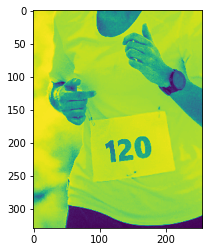

C:\Users\tom\AppData\Local\Temp/ipykernel_108056/1370764735.py:75: RuntimeWarning: invalid value encountered in true_divide
  grad_x_g = step_x_g / mag_g
C:\Users\tom\AppData\Local\Temp/ipykernel_108056/1370764735.py:76: RuntimeWarning: invalid value encountered in true_divide
  grad_y_g = step_y_g / mag_g


word_images [array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16), array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16), array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16), array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16), array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,

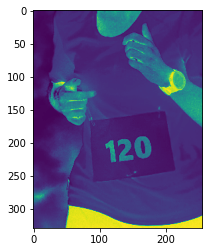

word_images []
SWTbib [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
./photos-out\0_3SWTimage_inverted.jpg
bib_number 


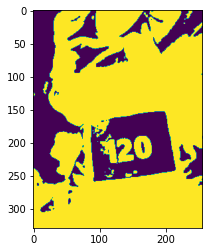

word_images [array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16), array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16), array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16), array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)]
SWTbib [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0.

In [34]:
img = cv2.imread('./photos/GloryDays/5.jpg')
findBibs(img,"./photos-out")